In [1]:
import pandas as pd

In [3]:
df = pd.read_csv('./data/sales.csv')
df.dropna(subset=['price'], inplace=True)

In [4]:
df.head()

,cost,price,weight,purchase_date,product_type,product_level,maker,ingredient,height,width,depth
0,$333k,"$300,492",3 Ton 90 Kg,Dec 19 2008,"Q,B",advanced,M14122,"IN732052,IN732053",2.76 meters,97 cm,26 cm
1,NaN,"$430,570",3 Ton 30 Kg,Sep 10 1997,"J,D",basic,NaN,"IN732054,IN732055,IN732056,IN732057,IN732058",2.67 meters,98 cm,26 cm
2,$270k,"$213,070",3 Ton 40 Kg,Sep 05 2001,"J,D",basic,NaN,"IN732054,IN732059,IN732060",3.0 meters,93 cm,24 cm
3,NaN,"$229,174",3 Ton 50 Kg,Dec 23 2016,U,advanced,M14123,"IN732061,IN732062,IN732063",2.5 meters,102 cm,27 cm
4,$97k,"$122,659",2 Ton 970 Kg,Jan 12 2000,"D,R",advanced,NaN,"IN732064,IN732065,IN732066",2.47 meters,101 cm,26 cm


In [5]:
df['year'] = pd.to_datetime(df.purchase_date).dt.year
train_raw = df[df.year < 2015].reset_index(drop=True)
test_raw = df[df.year >= 2015].reset_index(drop=True)

# 1. Decision Tree model with one feature

<font color='red'>Assignment:</font> Build a pipeline to predict **price** with **cost** using **DecisionTreeRegressor**.

In [6]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [7]:
class Cost_Transformer:
    def __init__(self):
        self.mean = 0
        
    def fit(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        self.mean = df.mean()
        
    def transform(self, X, y=None):
        df = pd.DataFrame()
        df['cost'] = X.cost.map(self.cost2num)
        return df.fillna(self.mean)
    
    def fit_transform(self, X, y=None):
        self.fit(X)
        return self.transform(X)

    def cost2num(self, x):
        if type(x) == str: 
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

In [8]:
ctf = Cost_Transformer()
ctf.fit_transform(train_raw).head()

,cost
0,333000.000000
1,166184.183143
2,270000.000000
3,97000.000000
4,59000.000000


In [10]:
features = list(train_raw.columns)
target = 'price'
features.remove(target)

In [11]:
# Build a function to transform price to numeric value 
def price2num(x):
    if type(x) == str:
        x = x.strip('$').replace(',','')
        return float(x)
    else:
        return x

In [12]:
X_train = train_raw[features]
y_train = train_raw[target].map(price2num)

X_test = test_raw[features]
y_test = test_raw[target].map(price2num)

In [13]:
steps = [('ctf', Cost_Transformer()),
#         ('Rescale', MinMaxScaler()),
         ('tree', DecisionTreeRegressor(random_state = 0))]
model = Pipeline(steps)

### Is scaling is necessary for decision tree? No.

In [14]:
model.fit(X_train, y_train)

Pipeline(steps=[('ctf',
                 <__main__.Cost_Transformer object at 0x0000022434B9BBB0>),
                ('tree', DecisionTreeRegressor(random_state=0))])

<font color='red'>Assignment:</font> Calculate train/test scores of this model.

In [15]:
y_train_pred = model.predict(X_train)

In [16]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 9.66e+04
train MSE: 2.32e+10
train R2: 0.456


In [17]:
y_test_pred = model.predict(X_test)

In [18]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.28e+05
test MSE: 5.42e+10
test R2: 0.372


<font color='red'>Assignment:</font> Plot the predcited **price** against **cost**.

In [19]:
import matplotlib.pylab as plt
%matplotlib inline

In [20]:
import numpy as np

def plot_cost_price(cost, price, model):
    plt.scatter(cost, price, alpha=0.3)
    x = pd.DataFrame()
    x['cost'] = np.linspace(0, 1e6)
    y = model.predict(x)
    plt.plot(x, y, color='r')
    plt.xlabel('cost')
    plt.ylabel('price')
    plt.xlim([0,1e6])
    plt.ylim([0,2e6])
    plt.show()

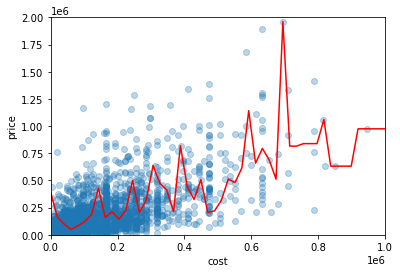

In [21]:
plot_cost_price(model.steps[0][1].fit_transform(X_train).cost, y_train, model)

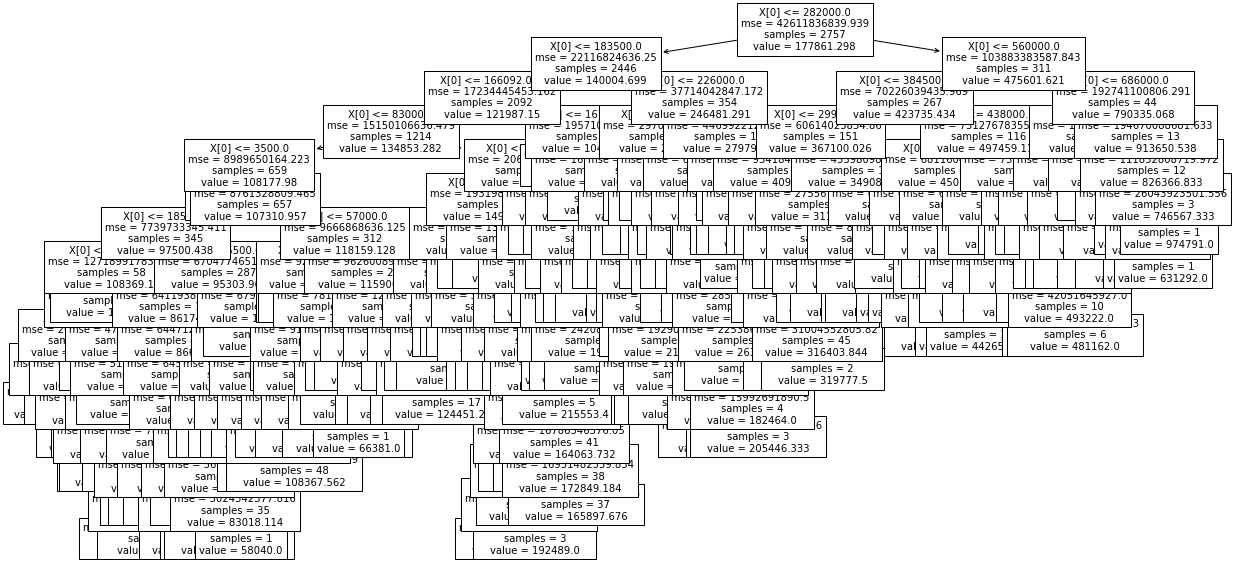

In [24]:
# Plot the decision tree
from sklearn import tree
fig, ax = plt.subplots(figsize=(20, 10))
tree.plot_tree(model.steps[1][1], fontsize=10)
plt.show()

<font color='red'>Question:</font> Does the decision tree model perform better than the linear regression model purely based on **cost**? Why is that?

### Yes, the performance of decision tree is better than linear regression in this case. Linear regression only works better when there is a clear linear relation between the feature(s) and the outcome whereas decision tree is better at catching the non-linear relation. However, without regulation, what decision tree generated here also has over-fitting issue.

<font color='red'>Question:</font> How does decision tree work? How is branch split?

### The Decision Tree models are non-linear models. Decision trees recursively split features with regard to their target variable’s purity. For the branching part, we calculate the purity among all data points in the leaves using different factors for splitting. We branch the tree based on the factor that provides the most impurity reduction. This splitting process continues until no further information gain can be made or a preset rule is met, e.g. the maximum depth of the tree is reached.

### Key part is to decrease impurity in each node after split. Two widely used purity (or impurity) measurements for classification: Gini, entropy. Regression uses variance.

Occasionally, interviewer asks how to calculate Gini or entropy.

### More on classification and regression using decision tree:

The difference between decision tree classification and decision tree regression is that in regression, each leaf represents a predicted value, as opposed to a class label.

Classification tree: https://www.youtube.com/watch?v=_L39rN6gz7Y&t=428s&ab_channel=StatQuestwithJoshStarmer

Regression tree: https://www.youtube.com/watch?v=g9c66TUylZ4&t=290s&ab_channel=StatQuestwithJoshStarmer

Reduction in Variance is a method for splitting the node used when the target variable is continuous, i.e., regression problems. It uses variance as a measure for deciding the feature on which node is split into child nodes.
1. For each split, individually calculate the variance of each child node
2. Calculate the variance of each split as the weighted average variance of child nodes
3. Select the split with the lowest variance


### Pruning

Pruning is used to control the size of the decision tree and to prevent a tree from overfitting.
- Pre-pruning (or called early stopping) involves stopping the tree before it has completed classifying the training set. You can tweak parameters such as min_samples_leaf and max_depth in DecisionTreeClassifier to achieve this type of pruning.
- Post-pruning allows the tree to classify the training set perfectly and then prunes the tree. In DecisionTreeClassifier, this pruning technique is parameterized by the cost complexity parameter, ccp_alpha. Greater values of ccp_alpha increase the number of nodes pruned.  

Ref: https://towardsdatascience.com/build-better-decision-trees-with-pruning-8f467e73b107

# 2. Decision Tree model with multiple features

<font color='red'>Assignment:</font> Build a decision-tree pipeline to predict **price** with **cost**, **weight**, **height**, **width**, **depth**, and **volume**.

In [38]:
from sklearn.base import TransformerMixin

class Transformer(TransformerMixin):
    '''
    A transformer class to extract numerical features
    (cost, weight, height, width, and depth) and replace
    the missing values with the averages in train data
    '''

    def __init__(self):  # maybe can use super() since it is inheritance?
        self.mean = 0
    
    def fit(self, X, y=None):
        '''
        Get mean
        Input: X datafrome
        '''
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        self.mean = df.mean()

    def transform(self, X, y=None):
        '''
        Transform data and fill na with mean
        Input: X dataframe
        '''
        df = pd.DataFrame()
        df['cost'] = X['cost'].map(self.cost2num)
        df['weight'] = X['weight'].map(self.weight2num)
        df['height'] = X['height'].map(self.height2num)
        df['width'] = X['width'].map(self.width2num)        
        df['depth'] = X['depth'].map(self.depth2num)
        df['volume'] = 100 * df['height'] * df['width'] * df['depth']
        return df.fillna(self.mean)
 
    def fit_transform(self, X, y=None):
        '''
        Combine fit and transform
        Input: X dataframe
        '''        
        self.fit(X)
        return self.transform(X)
        
    # Convert cost string to numeric (unit: $)        
    def cost2num(self, x):
        if type(x) == str:
            x = x.strip('$').strip('k')
            return float(x)*1000
        else:
            return x

    # Convert weight string to numeric (unit: kg)
    def weight2num(self, x):
        if type(x) == str:
            x = x.strip('Kg').strip().split(' Ton ')
            return float(x[0])*1000+float(x[1])
        else:
            return x
    
    # Convert height string to numeric (unit: cm)
    def height2num(self, x):
        if type(x) == str:
            x = x.strip('meters').strip()
            return float(x)*100
        else:
            return x        
    
    # Convert width string to numeric (unit: cm)
    def width2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

    # Convert depth string to numeric (unit: cm)
    def depth2num(self, x):
        if type(x) == str:
            x = x.strip('cm').strip()
            return float(x)
        else:
            return x   

In [39]:
# Test the transformer
tfm = Transformer()
tfm.fit_transform(train_raw).head()

,cost,weight,height,width,depth,volume
0,333000.000000,3090.0,276.0,97.0,26.0,69607200.0
1,166184.183143,3030.0,267.0,98.0,26.0,68031600.0
2,270000.000000,3040.0,300.0,93.0,24.0,66960000.0
3,97000.000000,2970.0,247.0,101.0,26.0,64862200.0
4,59000.000000,2930.0,271.0,96.0,25.0,65040000.0


In [49]:
steps = [('tfm', Transformer()), 
         ('dtr', DecisionTreeRegressor())]
model = Pipeline(steps)

In [50]:
model.fit(X_train, y_train)

Pipeline(steps=[('tfm', <__main__.Transformer object at 0x0000022435D0AFD0>),
                ('dtr', DecisionTreeRegressor())])

<font color='red'>Assignment:</font> Calculate the train/test scores.

In [51]:
y_train_pred = model.predict(X_train)

In [52]:
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 2.33e+03
train MSE: 2.34e+08
train R2: 0.995


In [53]:
y_test_pred = model.predict(X_test)

In [54]:
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.55e+05
test MSE: 7.09e+10
test R2: 0.178


<font color='red'>Assignment:</font> Plot the feature importance in a bar chart.

In [55]:
importances = model.steps[1][1].feature_importances_

In [56]:
importances

array([0.46389673, 0.12604615, 0.10032021, 0.09147208, 0.02168545,
       0.19657938])

([<matplotlib.axis.XTick at 0x22435d79eb0>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volume')])

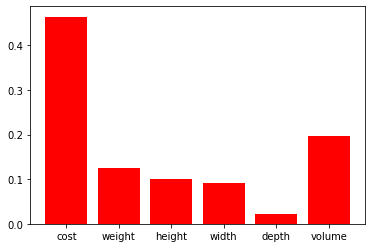

In [57]:
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volume'])

<font color='red'>Question:</font> How the feature importance values are calculated?

### Feature importance is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature.

<font color='red'>Assignment:</font> Retrain the model and rerun the above steps to see the changes in the results.

In [58]:
steps = [('tfm', Transformer()), 
         ('dtr', DecisionTreeRegressor())]
model = Pipeline(steps)
model.fit(X_train, y_train)

Pipeline(steps=[('tfm', <__main__.Transformer object at 0x0000022435DBE850>),
                ('dtr', DecisionTreeRegressor())])

In [59]:
y_train_pred = model.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 2.33e+03
train MSE: 2.34e+08
train R2: 0.995


In [60]:
y_test_pred = model.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.62e+05
test MSE: 7.48e+10
test R2: 0.132


([<matplotlib.axis.XTick at 0x22435dd3fd0>,
 [Text(0, 0, 'cost'),
  Text(1, 0, 'weight'),
  Text(2, 0, 'height'),
  Text(3, 0, 'width'),
  Text(4, 0, 'depth'),
  Text(5, 0, 'volume')])

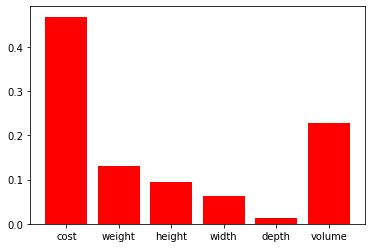

In [61]:
importances = model.steps[1][1].feature_importances_
plt.bar(range(len(importances)), importances, color="r", align = "center")
plt.xticks(range(len(importances)), ['cost', 'weight', 'height', 'width', 'depth', 'volume'])

<font color='red'>Question:</font> Do you see any problems with this model? Why is that?

### The model scores and feature importance values are not exactly the same. This happens because decision tree is sensitive to small changes in the data. In our case the change comes from the random status generator. 

random_state: Controls the randomness of the estimator. The features are always randomly permuted at each split, even if splitter is set to "best". When max_features < n_features, the algorithm will select max_features at random at each split before finding the best split among them. But the best found split may vary across different runs, even if max_features=n_features. That is the case, if the improvement of the criterion is identical for several splits and one split has to be selected at random. To obtain a deterministic behaviour during fitting, random_state has to be fixed to an integer.

# 3. Hyperparameter tuning

<font color='red'>Assignment:</font> Tune hyperparameters with k-fold cross validation to optimize model performance.

In [62]:
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [63]:
parameters = {'tree__max_depth': [3, 5, 10], 
              'tree__min_samples_leaf': range(30, 150, 30), 
              'tree__min_samples_split': [2, 3, 5]
             }

In [64]:
scorer = make_scorer(mean_squared_error, greater_is_better = False)

In [65]:
steps = [('tf', Transformer()),
         ('tree', DecisionTreeRegressor())]
model = Pipeline(steps)

In [66]:
model_gsv = GridSearchCV(model, parameters, cv = 3, scoring = scorer, n_jobs=-1)

In [67]:
model_gsv = model_gsv.fit(X_train, y_train)

In [68]:
model_gsv.best_params_

{'tree__max_depth': 5,
 'tree__min_samples_leaf': 90,
 'tree__min_samples_split': 2}

In [69]:
y_train_pred = model_gsv.predict(X_train)
print('train MAE: {0:.2e}'.format(mean_absolute_error(y_train, y_train_pred)))
print('train MSE: {0:.2e}'.format(mean_squared_error(y_train, y_train_pred)))
print('train R2: {0:.3f}'.format(r2_score(y_train, y_train_pred)))

train MAE: 1.04e+05
train MSE: 2.68e+10
train R2: 0.372


In [70]:
y_test_pred = model_gsv.predict(X_test)
print('test MAE: {0:.2e}'.format(mean_absolute_error(y_test, y_test_pred)))
print('test MSE: {0:.2e}'.format(mean_squared_error(y_test, y_test_pred)))
print('test R2: {0:.3f}'.format(r2_score(y_test, y_test_pred)))

test MAE: 1.24e+05
test MSE: 5.39e+10
test R2: 0.375


<font color='red'>Question:</font> What are the hyper parameters which can effetively affect model performance? How do they affect the performance respectively?

### I tuned three hyperparameters:
### (1) max_depth: a proper value ensures that almost all features have been given a chance to participate in becoming a decision node, but not too much so that we start splitting on arbitrary numeric cut off in numeric columns. 
### (2) min_samples_leaf: it was set to 1 by default, which would naturally make the tree over-fit and learn from the all the data points, including outliers. We increase it to less than 5% of the data points to stop the tree from prematurely classifying these outliers.
### (3) min_samples_split: this controls how similar the trees will look toward one another. This number needs to be not so large that branching stops prematurely, but not so small that the model becomes too flexible and results in low bias and high variance.

<font color='red'> Discussion: </font> How to effectively tune hyperparameters?

Official answer from sklearn https://scikit-learn.org/stable/modules/grid_search.html

Personal experience:
1. RandomizedSearchCV to randomly explore large parameter space (usually sklearn defaults are good starting point)
2. Coarse GridSearchCV to get understanding on the impact of variance-bias from each parameter 
https://colab.research.google.com/drive/1wQKzpm74jmAGCXDg6EohNc9BwfYJJ7Ps#scrollTo=NXGtMQMbWIlH
3. Fine GridSearchCV to get optimal number

keep cv low, keep n_estimators low for Randomforest, set n_jobs = -1


Interview tips:
You will need to show this step, but don't spend too much time on it.
You will also need to identify bias/variance in each case